In [1]:
import kaggle

# 'trolukovich/food11-image-dataset' 데이터셋 다운로드
kaggle.api.dataset_download_files('trolukovich/food11-image-dataset', path='imgs', unzip=False)

In [2]:
import zipfile

with zipfile.ZipFile('imgs/food11-image-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('imgs')

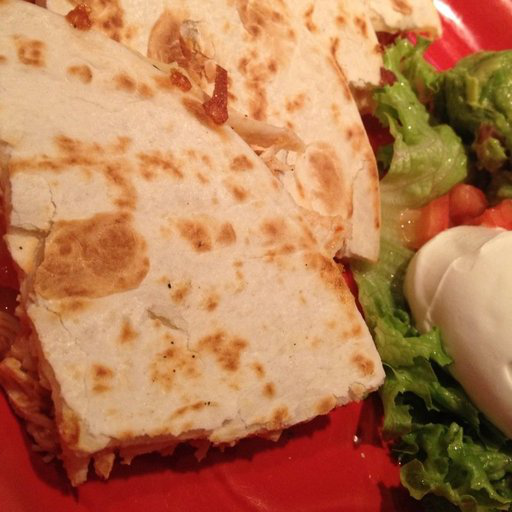

In [3]:
from PIL import Image

img = Image.open("imgs/evaluation/Bread/0.jpg")

img

In [5]:
from transformers import ViTFeatureExtractor, ViTModel

feature_extractor = ViTFeatureExtractor.from_pretrained('facebook/dino-vits16')
model = ViTModel.from_pretrained('facebook/dino-vits16')

print("Models loaded!")

Downloading: 100%|██████████| 244/244 [00:00<00:00, 69.0kB/s]
c:\Users\limgm\nd\envs\pytorch\lib\site-packages\huggingface_hub\file_download.py:123: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\limgm\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Downloading: 100%|██████████| 453/453 [00:00<00:00, 109kB/s]
Downloading: 100%|██

Models loaded!


In [6]:
img_tensor = feature_extractor(images=img, return_tensors="pt")
outputs = model(**img_tensor) #img tensor : 'pixel_values' 딕셔너리로 저장

embedding = outputs.pooler_output.detach().numpy().squeeze()

embedding

array([ 0.99360484,  0.34792283,  0.9501374 ,  0.57051724, -0.95467013,
       -0.92625296, -0.5524958 , -0.99785507,  0.91402817, -0.9431663 ,
       -0.99964464,  0.73265517,  0.21462868, -0.7729368 , -0.99933016,
        0.7809639 ,  0.98511523, -0.15624848, -0.5389057 , -0.37103727,
       -0.7707371 ,  0.01438036, -0.26651087,  0.8664451 , -0.35266164,
       -0.9981926 ,  0.9719462 , -0.86195344, -0.9225514 , -0.9872119 ,
       -0.5476662 , -0.21666181, -0.302512  ,  0.6122663 ,  0.98585165,
       -0.35414943, -0.96518946,  0.13390999, -0.9678031 , -0.970057  ,
        0.9963277 ,  0.88880515,  0.949329  ,  0.63444513, -0.8865986 ,
       -0.9192241 ,  0.79354566, -0.9766455 ,  0.9984392 ,  0.9865068 ,
       -0.99597085,  0.9691556 , -0.15808108,  0.48905033,  0.9988013 ,
        0.93793017, -0.6305337 ,  0.09021867, -0.6390878 ,  0.9475919 ,
        0.76607394, -0.9613685 ,  0.34879136,  0.9123714 ,  0.48822808,
       -0.99700433,  0.26091018,  0.9923436 ,  0.99329215,  0.85

In [7]:
embedding.shape

(384,)

In [20]:
img_tensor['pixel_values'].size() #size : torch.Size([1, 3, 224, 224])

torch.Size([1, 3, 224, 224])

In [96]:
import chromadb

client = chromadb.Client()

collection = client.create_collection("foods")

In [9]:
from glob import glob

img_list = sorted(glob("imgs/evaluation/*/*.jpg"))

len(img_list)

3347

In [12]:
img_path = "imgs/evaluation/Bread/0.jpg"
cls = img_path.split("/")[2]
print(cls)

Bread


In [10]:
img_list2 = sorted(glob("imgs/evaluation/*/[0-9].jpg"))

len(img_list2)

110

In [97]:
from tqdm import tqdm #tqdm : 진행표시 바 라이브러리

embeddings = [] #임베딩 된 이미지 벡터 저장
metadatas = []
ids = []

#이미지 번호를 인덱스로 사용?

for i, img_path in enumerate(tqdm(img_list2)): #i : 이미지 인덱스, img_path : 이미지 경로, 총 110번 반복
    img = Image.open(img_path) #이미지 오픈
    cls_temp = img_path.split("/")[1] #이미지 별 클래스 라벨 저장
    cls = cls_temp.split("\\")[1]
    #print(cls)
    img_tensor = feature_extractor(images=img, return_tensors="pt") #이미지 피처 텐서 저장, shape : torch.Size([1, 3, 224, 224])
    outputs = model(**img_tensor) #vit model에 딕셔너리 key, 이미지 텐서 투입 후, 결과 텐서 저장
    #outputs : shape (384, )
    embedding = outputs.pooler_output.detach().numpy().squeeze() #shape : (384,)
    #print(embedding.shape)

    embeddings.append(embedding.tolist()) #한 이미지당 imbedding 추가

    metadatas.append({
        "uri": img_path, #이미지 경로 추가
        "name": cls #라벨 추가
    })
    id = cls+'_'+str(i)
    #print(id)
    ids.append(id) #이미지 인덱스 번호 추가

print("Done!")

100%|██████████| 110/110 [00:26<00:00,  4.23it/s]

Done!


In [98]:
print(ids[0])

Bread_0


In [99]:
print(len(embeddings))
len(embeddings[0])

110


384

In [90]:
print(len(metadatas))

110


In [91]:
print(metadatas[0])

{'uri': 'imgs/evaluation\\Bread\\0.jpg', 'name': 'Bread'}


In [92]:
print(ids[0])

0


In [93]:
print(len(ids))

110


In [100]:
collection.add( #db에 데이터 추가
    embeddings=embeddings, #image tensor 
    metadatas=metadatas, #url, image label
    ids=ids #image id
)

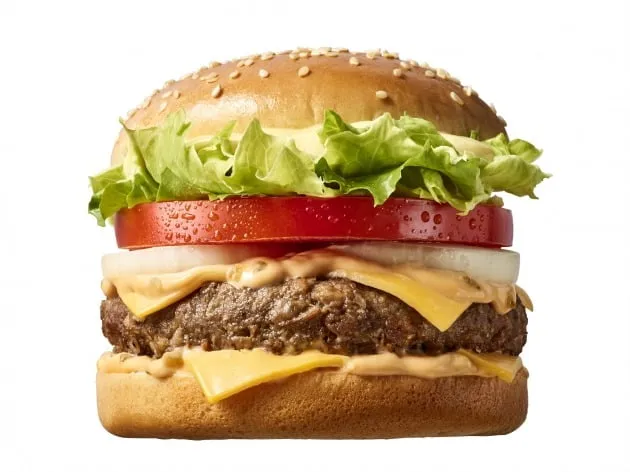

In [101]:
import requests

test_img = Image.open(requests.get("https://i.imgur.com/yNp6qTS.png", stream=True).raw).convert("RGB")

test_img

In [102]:
test_img_tensor = feature_extractor(images=test_img, return_tensors="pt")
test_outputs = model(**test_img_tensor)

test_embedding = test_outputs.pooler_output.detach().numpy().squeeze()

test_embedding.shape

(384,)

In [106]:
#test_embedding_tolist = test_embedding.tolist()

query_result = collection.query(
    query_embeddings=test_embedding.tolist(),
    n_results=3,
)


In [107]:
query_result

{'ids': [['Bread_8', 'Bread_2', 'Vegetable-Fruit_108']],
 'embeddings': None,
 'documents': [[None, None, None]],
 'metadatas': [[{'uri': 'imgs/evaluation\\Bread\\8.jpg', 'name': 'Bread'},
   {'uri': 'imgs/evaluation\\Bread\\2.jpg', 'name': 'Bread'},
   {'uri': 'imgs/evaluation\\Vegetable-Fruit\\8.jpg',
    'name': 'Vegetable-Fruit'}]],
 'distances': [[139.9814910888672, 262.16558837890625, 294.715576171875]]}

In [108]:
import numpy

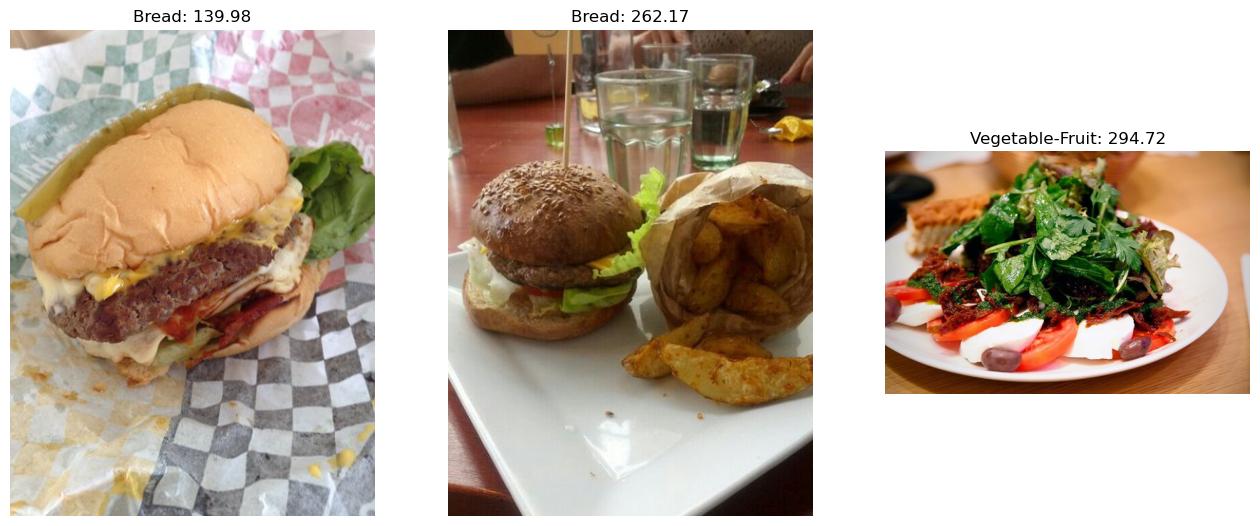

In [109]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(16, 10))

for i, metadata in enumerate(query_result["metadatas"][0]): #metadatas 0 : url & name dictionary
    distance = query_result["distances"][0][i] #1 dimention list

    axes[i].imshow(Image.open(metadata["uri"])) #image path
    axes[i].set_title(f"{metadata['name']}: {distance:.2f}") #image class & similarity distance
    axes[i].axis("off")

In [111]:
def query(img_url, n_results=3): #img_url : query image url
    test_img = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")

    test_img_tensor = feature_extractor(images=test_img, return_tensors="pt") #extract image feature tensor
    test_outputs = model(**test_img_tensor) #return output tensor

    test_embedding = test_outputs.pooler_output.detach().cpu().numpy().squeeze() #image embedding vector

    query_result = collection.query(
        query_embeddings=test_embedding.tolist(),
        n_results=n_results,
    ) #query function

    fig, axes = plt.subplots(1, 4, figsize=(16, 10))

    axes[0].imshow(test_img)
    axes[0].set_title("Query")
    axes[0].axis("off")

    for i, metadata in enumerate(query_result["metadatas"][0]): #1 dimention dictionary
        distance = query_result["distances"][0][i] #1 dimention distance

        axes[i+1].imshow(Image.open(metadata["uri"])) #url image open
        axes[i+1].set_title(f"{metadata['name']}: {distance:.2f}")
        axes[i+1].axis("off")

    return query_result

{'ids': [['Dairy product_14', 'Meat_54', 'Rice_74']],
 'embeddings': None,
 'documents': [[None, None, None]],
 'metadatas': [[{'uri': 'imgs/evaluation\\Dairy product\\4.jpg',
    'name': 'Dairy product'},
   {'uri': 'imgs/evaluation\\Meat\\4.jpg', 'name': 'Meat'},
   {'uri': 'imgs/evaluation\\Rice\\4.jpg', 'name': 'Rice'}]],
 'distances': [[259.2635498046875, 269.01800537109375, 281.0303955078125]]}

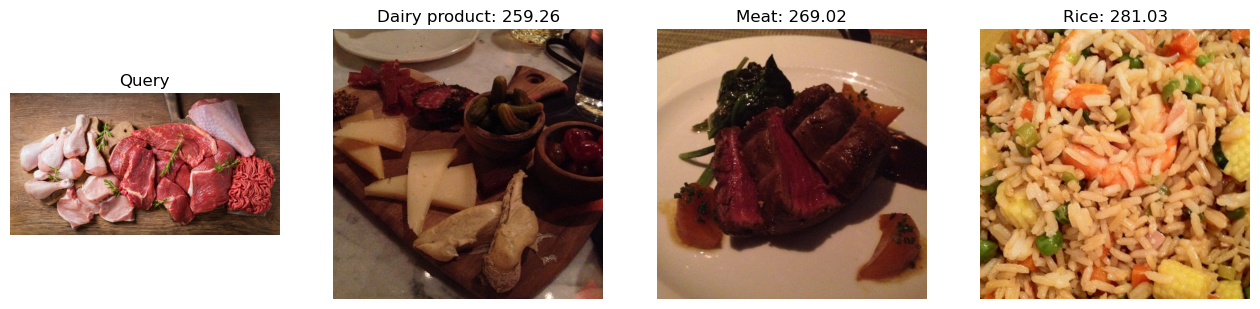

In [112]:
query("https://i.imgur.com/QCado9g.jpg") #query image url

{'ids': [['Dairy product_13', 'Dairy product_14', 'Meat_53']],
 'embeddings': None,
 'documents': [[None, None, None]],
 'metadatas': [[{'uri': 'imgs/evaluation\\Dairy product\\3.jpg',
    'name': 'Dairy product'},
   {'uri': 'imgs/evaluation\\Dairy product\\4.jpg', 'name': 'Dairy product'},
   {'uri': 'imgs/evaluation\\Meat\\3.jpg', 'name': 'Meat'}]],
 'distances': [[188.79440307617188, 198.0926971435547, 225.87896728515625]]}

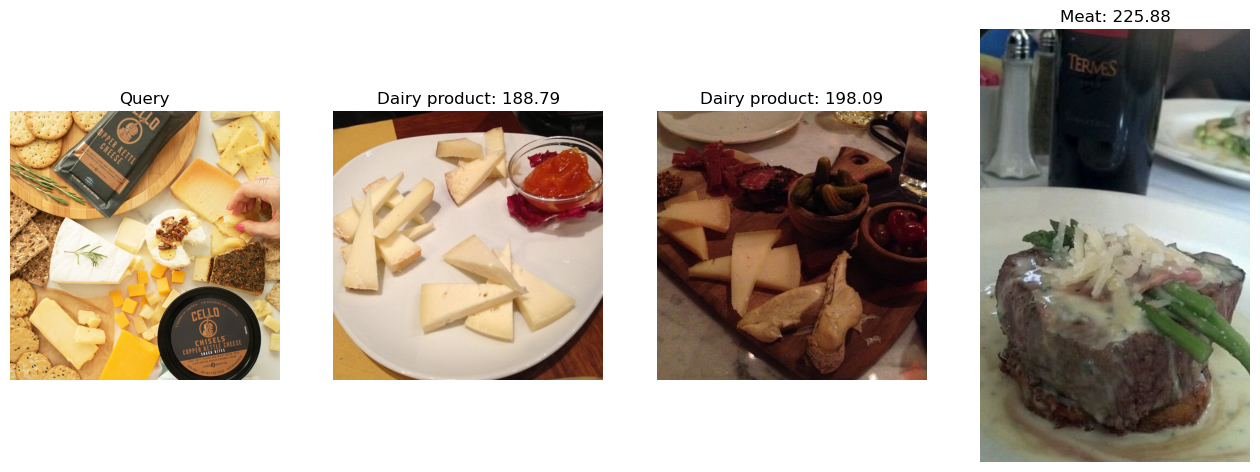

In [113]:
query("https://i.imgur.com/lf5C0LI.png")

{'ids': [['Seafood_83', 'Rice_77', 'Rice_73']],
 'embeddings': None,
 'documents': [[None, None, None]],
 'metadatas': [[{'uri': 'imgs/evaluation\\Seafood\\3.jpg', 'name': 'Seafood'},
   {'uri': 'imgs/evaluation\\Rice\\7.jpg', 'name': 'Rice'},
   {'uri': 'imgs/evaluation\\Rice\\3.jpg', 'name': 'Rice'}]],
 'distances': [[225.71002197265625, 226.89134216308594, 233.848876953125]]}

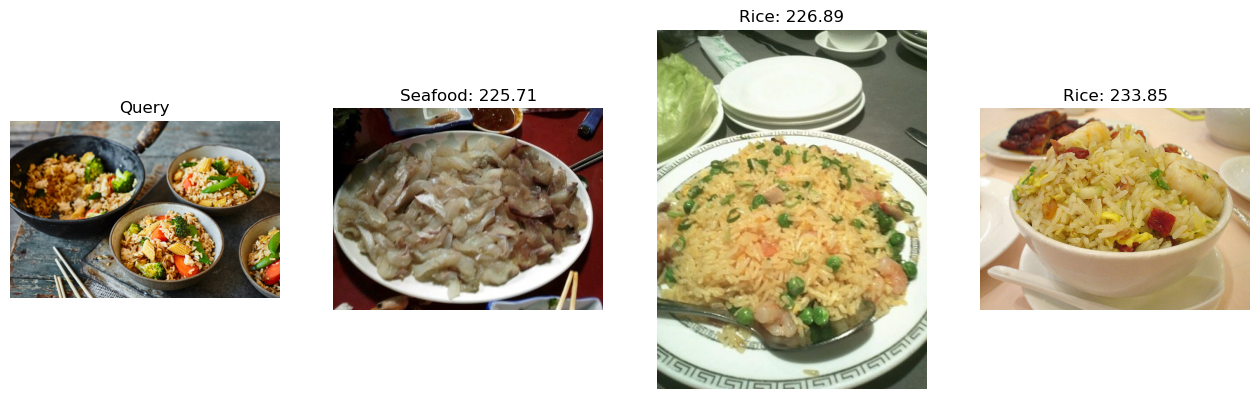

In [114]:
query("https://i.imgur.com/WlLv0i9.png")